### Workbook for calculating the reflectivity of an anisotropic stratified media

In [43]:
#Package Initialization
#Refnx is used for structure generation and fitting routines
#Ani_Reflect_Model is the custom application for anisotropic media

%matplotlib inline

# start off with the necessary imports
import os.path
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import corner

#required modules from refnx
from refnx import version as refnx_version
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective
from refnx.reflect.ani_reflect_model import *
from refnx.reflect.ani_structure import *

In [15]:
#Version control
print('Refnx version -',refnx_version.version)
print('numpy version -',np.version.version)

Refnx version - 0.1.11
numpy version - 1.18.1


#### Import Dataset here if intersted in fitting

In [37]:
data = ReflectDataset('Thelen_250eV.txt')

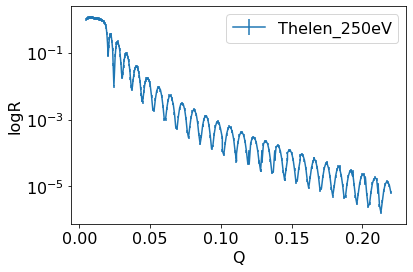

In [38]:
#Quick plot to verify data
data.plot()
plt.legend()
plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('logR')
plt.legend()

### Generate dielectric tensor components for slab assignment

#### Isotropic, Uniaxial, and Biaxial (not verified) are supported

In [19]:
##Create dielectric tensors
#Isotropic media can be either an np.ndarray or complex scalar
#Uniaxial media must be 3x3 numpy array
#Biaxial media must be 3x3 numpy array

Silicon = (0.98805666 + 1j*0.008500482) #From CXRO @ 250eV
SiO2 = (0.988016631 + 1j*0.00463295) #From CXRO @ 250eV
Pos = (0.994527941 + 1j*0.000375501) # From CXRO @ 250eV
Vac = np.eye(3) # Vacuum permativity


#### Create SLD objects that house the dielectric tensor

In [20]:
#Generate SLDs

Si_250eV = ani_SLD(Silicon, name='Si')
SiO2_250eV = ani_SLD(SiO2, name='SiO2')
Pos_250eV = ani_SLD(Pos, name='POS')
Vac = ani_SLD(Vac, name="Air")

#### Create 'slab' objects that represent a layer in the model

'slab' = 'SLD'(thickness, roughness)

    --Substrate thickness can be any value (not used in calculation) 
    --Roughness corresponds to the top of the layer, I.E. The side closest to the superstrate
    --Superstrate is not assigned through a 'slab' ~~See structure generation

In [22]:
# Generate Slabs
# Slab objects are created from SLD objects in this way
#Slab = SLD(thickness, roughness)

#Create layer for Posaconozole 334k @250eV
pos_layer = Pos_250eV(725.44, 3.06)
sio2_layer = SiO2_250eV(11.8552,1.9067)
substrate = Si_250eV(0,0.1)



#### Assign fitting parameters

    --default is to remain constant
    
##### List of parameters ~
    .thick -> Layer thickness
    .rough -> Layer roughness
    .sldAvg -> Trace of dielectric tensor (real)
    .isldAvg -> Trace of dielectric tensor (imaginary)
    .sldxx -> xx component of tensor (real)
    .isldxx -> xx component of tensor (imaginary)
    .sldyy -> yy component of tensor (real)
    .isldyy -> yy component of tensor (imaginary)
    .sldzz -> zz component of tensor (real)
    .isldzz -> zz component of tensor (imaginary)

In [11]:
sio2_layer.thick.setp(bounds=(11.5, 12), vary=True)
sio2_layer.rough.setp(bounds=(1.7, 2), vary=True)

pos_layer.thick.setp(bounds=(720, 730), vary=True)
pos_layer.rough.setp(bounds=(2, 4), vary=True)
pos_layer.sld.xx.setp(bounds=(0.95, 1), vary=False)
pos_layer.sld.yy.setp(bounds=(0.95, 1), vary=False)
pos_layer.sld.zz.setp(bounds=(0.95, 1), vary=False)
pos_layer.sld.izz.setp(bounds=(0.95, 1), vary=False)

substrate.rough.setp(bounds=(0,1),vary=True)

#### Generate the structure object

'structure' = superstrate (sld) | top layer (slab) | ... | bottom layer (slab) | substrate (slab)

In [24]:
structure = Vac | pos_layer | sio2_layer | substrate

In [25]:
print(structure)

________________________________________________________________________________
Structure:                
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - sldAvg' , value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - isldAvg', value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - sldxx' , value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - isldxx' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - sldyy' , value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - isldyy' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - sldzz' , value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - isldzz' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds

#### Plot SLD Profile
    Quick visualization of SLD profile
    Plots sldAvg (real) as a function of depth

In [26]:
zprof, sldprof, tensorprof = structure.sld_profile()

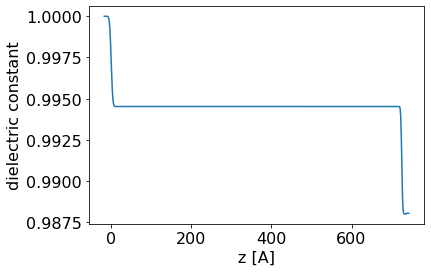

In [27]:
#plot results
plt.plot()
plt.plot(zprof, sldprof[0,:])
plt.ylabel('dielectric constant')
plt.xlabel('z [A]')
plt.show()

### Setup scattering model

    Inputs
        scale  - multiplicative scale
        bkg    - additive background
        dq     - gaussian q smearing
        Energy - List of energies as a numpy array (only 1 unless simulating)
        pol    - polarization of the output
                   Use 'None' if you want an array containing all 4 outputs 'ss', 'sp', 'ps', 'pp'
                   Single output is for current fitting routines as of 06/05/2020

In [28]:
# a ReflectModel is made from the Structure.
# ReflectModel calculates smeared reflectivity, applies scaling factor and background
Energy = np.array([250])
model = ani_ReflectModel(structure, scale=1,bkg=0,dq=0,Energy=Energy,pol='s')

model.scale.setp(bounds=(0.6, 1.2), vary=False)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=False)

#### Simulate scattering
    Inputs
        qvals

In [32]:
qvals = np.linspace(0.005,0.25,300)
numpnts = len(qvals)
model_reflectivity  = model.model(qvals) #TestModelT

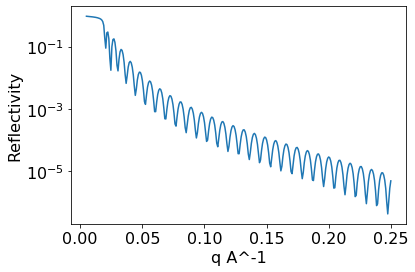

In [35]:
#plot Reflectivity
plt.plot()
plt.yscale('log')
#Single polarization
plt.plot(qvals,model_reflectivity[:])
#Full plot (0,0 - spol : 1,1 - ppol)
#plot.plot(qvals,model_reflectivity[:,0,0],qvals,model_reflectivity[:,1,1])
plt.ylabel('Reflectivity')
plt.xlabel('q A^-1')
plt.show()

### Fitting process
#### Create an object with the model and data

In [39]:
objective = Objective(model, data, transform=Transform('logY'))

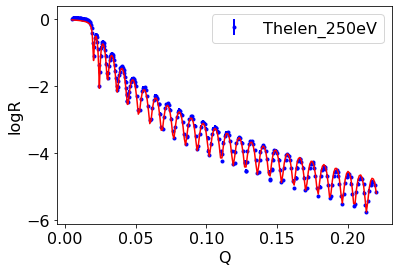

In [40]:
# an Objective has a plot method, which is a quick visualisation. You need
# matplotlib installed to create a graph
objective.plot()
plt.legend()
plt.xlabel('Q')
plt.ylabel('logR')
plt.legend()

In [23]:
# CurveFitters do the fitting/sampling
fitter = CurveFitter(objective)

In [ ]:
# do an initial fit with differential evolution
res = fitter.fit('differential_evolution')

### Quick MCMC routine 
#### From refnx tutorial ~

In [ ]:
fitter.sample(200)
fitter.reset()

 19%|█▉        | 38/200 [10:41<46:43, 17.30s/it]  

In [ ]:
res = fitter.sample(15, nthin=100)

In [42]:
#print(objective)

In [ ]:
objective.corner();

In [ ]:
objective.plot(samples=300);